# Region-scale glacier analysis


The previous notebook demonstrated using xarray to analyze surface velocity data for an individual glacier. This notebook will show how we can examine spatial variability in surface velocity within a group of glaciers. To do this we will use **xarray** as well as **geopandas**, **geocube**, and **pandas**. We will start by using `.make_geocube()` to rasterize a vector object in the shape of an **ITS_LIVE** velocity raster object. We will then use the rasterized vector to group the **ITS_LIVE** object by individual glaciers and then calculate summary statistics of surface velocity for each glacier. The goal in this work flow is to end up with a **pandas dataframe** where each row is an individual glacier and columns for various surface velocity summary statistics. 

## Learning goals

### Concepts
- Querying and accessing raster data from cloud object storage
- Accessing and manipulating vector data
- Handling coordinate reference information
- Calculating and visualizing summary statistics

### Techniques
- Access cloud-hosted [Zarr](https://zarr.readthedocs.io/en/stable/) data cubes using [Xarray](https://xarray.dev/)
- Reading [GeoParquet](https://geoparquet.org/) vector data using [GeoPandas](https://geopandas.org/en/stable/)
- Rasterize vector objects using [Geocube]()
- Spatial joins of vector datasets using [GeoPandas](https://geopandas.org/en/stable/)
- Using [dask](https://www.dask.org/) to work with out-of-memory data
- Calculating summary statistics of [Xarray](https://xarray.dev/) and [Pandas](https://pandas.pydata.org/) objects
- Data visualization using [Pandas](https://pandas.pydata.org/)
- Interactive data visualization with [GeoPandas](https://geopandas.org/en/stable/)
   
### Other useful resources
These are resources that contain additional examples and discussion of the content in this notebook and more.
- [Xarray user guide](https://docs.xarray.dev/en/stable/user-guide/index.html)
- [How do I...](https://docs.xarray.dev/en/stable/howdoi.html) this is **very** helpful!
- [Xarray High-level computational patterns](https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html) discussion of concepts and associated code examples
- [Parallel computing with dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html) Xarray tutorial demonstrating wrapping of dask arrays

## Software + Setup

In [1]:
%xmode minimal

Exception reporting mode: Minimal


In [2]:
import os
import json
import urllib.request
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import Point
from geocube.api.core import make_geocube

%config InlineBackend.figure_format='retina'

In [3]:
import itslivetools

## Accessing, reading raster data (ITS_LIVE velocity data)

In [4]:
itslive_catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

In [5]:
url = itslivetools.find_granule_by_point([95.180191, 30.645973])
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr'

In [6]:
dc = itslivetools.read_in_s3(url)
dc

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2022-06-07T04:21:44...
  * x                           (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The `mid_date` dimension of the `dc` object isn't in chronlogical order, so let's sort by this dimension:

In [7]:
dc = dc.sortby('mid_date')

Create a `crs` object based on the `projection` data variable of the data cube (`dc`) object.

In [8]:
crs = f'EPSG:{dc.projection}'
crs

'EPSG:32646'

## Reading vector data (glacier outlines)

In [9]:
se_asia = gpd.read_parquet('rgi7_region15_south_asia_east.parquet')
se_asia.head(3)

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry
0,RGI2000-v7.0-G-15-00001,15,15-01,G078088E31398N,866850,752,2002-07-10T00:00:00,78.087891,31.398046,44,...,4662.2950,4699.2095,4669.4720,4671.4253,13.427070,122.267290,4,COPDEM30,173,"POLYGON Z ((78.08905 31.39784 0.00000, 78.0889..."
1,RGI2000-v7.0-G-15-00002,15,15-01,G078125E31399N,867227,752,2002-07-10T00:00:00,78.123699,31.397796,44,...,4453.3584,4705.9920,4570.9473,4571.2770,22.822983,269.669144,7,COPDEM30,1113,"POLYGON Z ((78.12556 31.40257 0.00000, 78.1255..."
2,RGI2000-v7.0-G-15-00003,15,15-01,G078128E31390N,867273,752,2000-08-05T00:00:00,78.128510,31.390287,44,...,4791.7593,4858.6807,4832.1836,4827.6700,15.626262,212.719681,6,COPDEM30,327,"POLYGON Z ((78.12960 31.39093 0.00000, 78.1296..."


How many glaciers are in this dataframe?

In [10]:
se_asia['rgi_id'].nunique()

18587

What coordinate reference system is this dataframe in? 

In [11]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The vector dataset is in WGS 84, meaning that its coordinates are in degrees latitude and longitude rather than meters N and E. We will project this dataset to match the projection of the raster dataset.

## Handling projections

Let's project this dataframe to match the CRS of the itslive dataset

In [12]:
#project rgi data to match itslive
se_asia_prj = se_asia.to_crs(crs) #we know the epsg from the projection variable of the dc object
se_asia_prj.head(3)

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry
0,RGI2000-v7.0-G-15-00001,15,15-01,G078088E31398N,866850,752,2002-07-10T00:00:00,78.087891,31.398046,44,...,4662.2950,4699.2095,4669.4720,4671.4253,13.427070,122.267290,4,COPDEM30,173,"POLYGON Z ((-924868.476 3571663.111 0.000, -92..."
1,RGI2000-v7.0-G-15-00002,15,15-01,G078125E31399N,867227,752,2002-07-10T00:00:00,78.123699,31.397796,44,...,4453.3584,4705.9920,4570.9473,4571.2770,22.822983,269.669144,7,COPDEM30,1113,"POLYGON Z ((-921270.161 3571706.471 0.000, -92..."
2,RGI2000-v7.0-G-15-00003,15,15-01,G078128E31390N,867273,752,2000-08-05T00:00:00,78.128510,31.390287,44,...,4791.7593,4858.6807,4832.1836,4827.6700,15.626262,212.719681,6,COPDEM30,327,"POLYGON Z ((-921061.745 3570342.665 0.000, -92..."


In [13]:
se_asia_prj['rgi_id'].str.slice(18)

0        00001
1        00002
2        00003
3        00004
4        00005
         ...  
18582    18583
18583    18584
18584    18585
18585    18586
18586    18587
Name: rgi_id, Length: 18587, dtype: object

Give each glacier (row) a unique integer key that is related to that glacier's RGIId. We will use this later. Be careful that the `RGI_int` column is composed of **integers** not strings.

In [14]:
se_asia_prj['RGI_int'] = se_asia_prj['rgi_id'].str.slice(18,).astype(int)
se_asia_prj.RGI_int.dtype

dtype('int64')

To start with, we will look only at glaciers larger in area than 5km2. Subset the dataset to select for those glaciers

In [15]:
se_asia_prj = se_asia_prj.loc[se_asia_prj['area_km2'] > 5.]
se_asia_prj.head()

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry,RGI_int
59,RGI2000-v7.0-G-15-00060,15,15-01,G078577E31191N,871719,752,2000-08-05T00:00:00,78.553292,31.174611,44,...,6043.9136,5224.0610,5141.7990,17.677896,249.340500,7,COPDEM90,13928,"POLYGON Z ((-880436.185 3544730.055 0.000, -88...",60
66,RGI2000-v7.0-G-15-00067,15,15-01,G078523E31112N,871438,752,2000-08-05T00:00:00,78.521258,31.116022,44,...,5788.4610,4325.8790,4543.5195,18.882126,351.197868,1,COPDEM30,7044,"POLYGON Z ((-888722.833 3534458.887 0.000, -88...",67
157,RGI2000-v7.0-G-15-00158,15,15-01,G078843E31150N,874200,752,2002-07-10T00:00:00,78.843177,31.150501,44,...,5514.8880,5215.9690,5198.8105,12.894007,86.556990,3,COPDEM30,4981,"POLYGON Z ((-856766.704 3533377.312 0.000, -85...",158
209,RGI2000-v7.0-G-15-00210,15,15-01,G078779E31218N,873926,752,2002-07-10T00:00:00,78.814979,31.218553,44,...,6041.6123,5158.5570,5126.2070,12.179309,41.205524,2,COPDEM90,18374,"POLYGON Z ((-869202.097 3540392.546 0.000, -86...",210
229,RGI2000-v7.0-G-15-00230,15,15-01,G078544E31029N,871696,752,2000-08-05T00:00:00,78.550250,31.038592,44,...,6254.6704,5249.8203,5189.1060,20.423279,355.937175,1,COPDEM90,10797,"POLYGON Z ((-884033.521 3525419.927 0.000, -88...",230


Next, want to subset the RGI dataset by the spatial extent of the ITS_LIVE data.
First, get the bbox of the ITS_LIVE data as a vector

In [16]:
dc_bbox = itslivetools.get_bounds_polygon(dc)

In [17]:
dc_bbox.crs

<Projected CRS: EPSG:32646>
Name: WGS 84 / UTM zone 46N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.
- bounds: (90.0, 0.0, 96.0, 84.0)
Coordinate Operation:
- name: UTM zone 46N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Rasterize vector objects

Subset RGI dataset:  
To do this we will use a [spatial join](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html). Here we use an `inner join` but there are various methods to customize the spatial join operation. Find more info [here](https://geopandas.org/en/stable/gallery/spatial_joins.html). 

In [18]:
rgi_sub = gpd.sjoin(se_asia_prj, dc_bbox, how='inner')
rgi_sub.head()

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry,RGI_int,index_right
11630,RGI2000-v7.0-G-15-11631,15,15-03,G095124E30309N,927529,752,2003-07-24T00:00:00,95.106696,30.299816,46,...,4881.6580,4866.093,21.731916,45.774250,2,COPDEM90,19653,"POLYGON Z ((698995.535 3356459.046 0.000, 6990...",11631,0
11631,RGI2000-v7.0-G-15-11632,15,15-03,G095138E30348N,927618,752,2002-07-10T00:00:00,95.137897,30.347701,46,...,5107.2480,5112.531,19.250132,212.500549,6,COPDEM30,3968,"POLYGON Z ((705772.753 3360152.416 0.000, 7057...",11632,0
11642,RGI2000-v7.0-G-15-11643,15,15-03,G095210E30329N,927917,752,1997-08-24T00:00:00,95.209673,30.329234,46,...,5023.0493,4969.326,23.261293,62.829437,2,COPDEM30,5108,"POLYGON Z ((713890.435 3356601.497 0.000, 7138...",11643,0
11672,RGI2000-v7.0-G-15-11673,15,15-03,G095324E30363N,928296,752,2007-08-20T00:00:00,95.323927,30.363373,46,...,5020.7920,5009.677,20.035536,43.020733,2,COPDEM30,7190,"POLYGON Z ((720536.806 3361488.071 0.000, 7205...",11673,0
11735,RGI2000-v7.0-G-15-11736,15,15-03,G095203E30636N,927889,752,2002-07-10T00:00:00,95.203044,30.636060,46,...,5383.6210,5355.023,14.739693,28.799190,2,COPDEM30,4540,"POLYGON Z ((712706.746 3390103.661 0.000, 7126...",11736,0


Write crs of dc object. Event hough it is stored in the projection attribute, we want the projection to be stored as a rioxarray attribute so that it can be used in rioxarray methods.

In [19]:
dc = dc.rio.write_crs(crs)

In [20]:
rgi_sub = rgi_sub.drop('index_right', axis=1)

In [21]:
len(rgi_sub) # number of glaciers in the subset

28

Now, use the `.make_geocube()` function. This essentially takes a vector object (`rgi_sub`) and rasterizes it, returning an xarray object with the same structure as the object you provide for the `like =` argument (in our case that is `dc`). This example relies greatly on the [zonal statistics example](https://corteva.github.io/geocube/html/examples/zonal_statistics.html) in the **geocube** documentation, which contains additional helpful details. 

In [22]:
dc

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, y: 833, x: 833)
Coordinates:
    mapping                     int64 0
  * mid_date                    (mid_date) datetime64[ns] 1986-09-11T03:31:15...
  * x                           (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [23]:
out_grid = make_geocube(
    vector_data = rgi_sub,
    measurements = ["RGI_int"],
    like = dc
)
out_grid

<xarray.Dataset>
Dimensions:      (y: 833, x: 833)
Coordinates:
  * y            (y) float64 3.4e+06 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06 3.3e+06
  * x            (x) float64 7.001e+05 7.003e+05 7.004e+05 ... 7.999e+05 8e+05
    spatial_ref  int64 0
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

Now each glacier in the geodataframe `rgi_sub` has been coded with a unique integer value that corresponds to that glacier's Randolph Glacier Inventory ID. 

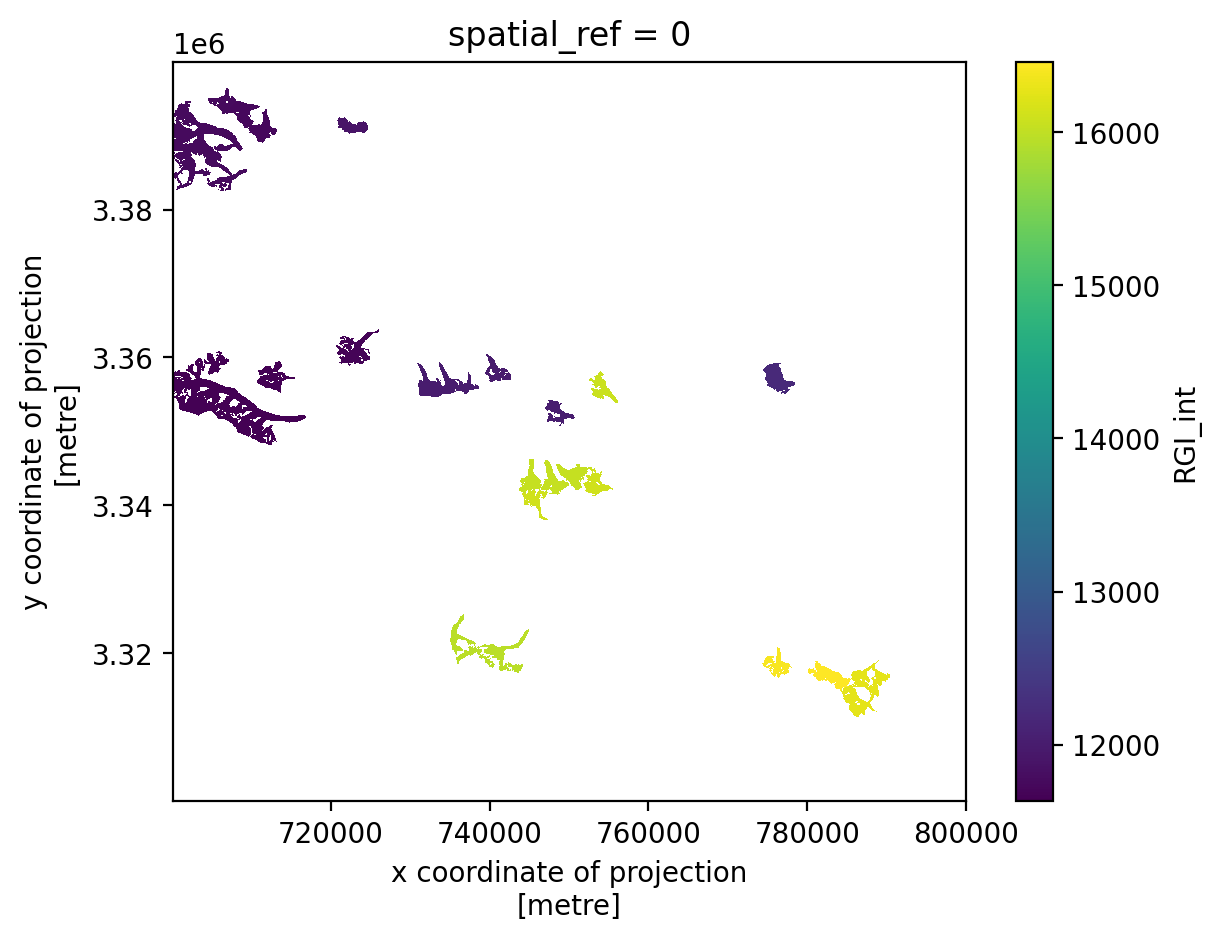

In [24]:
out_grid.RGI_int.plot();

Before moving forward, we will take a temporal subset of the full dataset to make it a bit easier to work with. We will also compute the mean along the time dimension and calculate the magnitude of velocity usign the velocity component variables. 

Then, merge the rasterized vector and the dataset containing the velocity data into an xarray dataset:

In [25]:
dc_sub = dc.isel(mid_date=slice(400,500))

In [26]:
dc_sub_2d = dc_sub.mean(dim='mid_date')

In [27]:
dc_sub_2d['v_mag'] = np.sqrt(dc_sub_2d.vx**2+dc_sub_2d.vy**2)

## Combining data 
```{note}
The following cell is very computationally intensive. It is executed here for the sake of demonstration but if you are running this code yourself be aware that it may not run/ may take a very long time to run. Consider taking a spatial subset of the dataset.
```

In [28]:
out_grid['v'] = (dc_sub_2d.v_mag.dims, dc_sub_2d.v_mag.values, dc_sub_2d.v_mag.attrs, dc_sub_2d.v_mag.encoding)

Assign the `RGI_int` object as a `coordinate variable` of the `xarray.Dataset` rather than a `data_var`. 

In [29]:
out_grid = out_grid.assign_coords({'RGI_int':out_grid.RGI_int})

### Grouping by RGI ID
Now, we will use `.groupby()` to group the dataset by the RGI ID:

In [30]:
grouped_ID = out_grid.groupby('RGI_int')

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


### Calculating summary statistics 

Compute summary statistics for a single variable on the grouped object:

In [34]:
grid_mean_sp = grouped_ID.mean(dim=...).rename({'v': 'speed_mean'})
grid_median_sp = grouped_ID.median(dim=...).rename({'v': 'speed_median'})
grid_max_sp = grouped_ID.max(dim=...).rename({'v': 'speed_max'})
grid_min_sp = grouped_ID.min(dim=...).rename({'v': 'speed_min'})
  

Check if the data arrays (`RGI_int`) are equal, must be the case for `xr.merge()` in next step

In [35]:
print(grid_mean_sp.RGI_int.equals(grid_mean_sp.RGI_int))
print(grid_median_sp.RGI_int.equals(grid_median_sp.RGI_int))
print(grid_max_sp.RGI_int.equals(grid_max_sp.RGI_int))
print(grid_min_sp.RGI_int.equals(grid_min_sp.RGI_int))

True
True
True
True


### Transitioning from ‘lazy’ operations to in-memory

Merge and convert the lazy object to an in-memory equivalent using dask [`.compute()`](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.compute.html). Once it is in-memory, we can convert it to a pandas dataframe.

In [36]:
zonal_stats = xr.merge([grid_mean_sp, grid_median_sp, grid_max_sp, grid_min_sp]).compute()

In [37]:
zonal_stats_df = zonal_stats.to_dataframe()

In [38]:
zonal_stats_df = zonal_stats_df.reset_index()

In [39]:
zonal_stats_df = zonal_stats_df.drop(['spatial_ref'], axis=1)
zonal_stats_df

,RGI_int,speed_mean,speed_median,speed_max,speed_min
0,11631.0,43.229496,22.201803,357.174896,0.197642
1,11632.0,12.765533,11.598662,43.169296,0.258909
2,11643.0,18.185356,15.985531,87.176575,0.078567
3,11673.0,23.413357,17.378513,135.973846,0.225877
4,11736.0,18.280186,14.794738,117.458504,0.760345
5,11740.0,17.366793,15.020761,65.095032,1.400108
6,11746.0,17.681360,15.402331,65.298370,1.013794
7,11754.0,25.471052,19.809713,186.470001,0.552978
8,11759.0,19.896990,17.988567,91.692764,0.567878
9,11766.0,23.918291,20.536091,114.969078,1.363080


Now, make a new object (`rgi_itslive`) where you merge the zonal stats dataframe onto the GeoPandas.GeoDataframe object containing the RGI glacier outlines. 

In [40]:
rgi_itslive = rgi_sub.loc[rgi_sub['area_km2'] > 5.]

In [41]:
rgi_itslive = pd.merge(rgi_sub, right =  zonal_stats_df, how='inner', on='RGI_int')

In [42]:
rgi_itslive['rgi_id'].nunique()

28

## Data visualization
Now we can start to visualize the prepared dataset:

### Pandas plotting

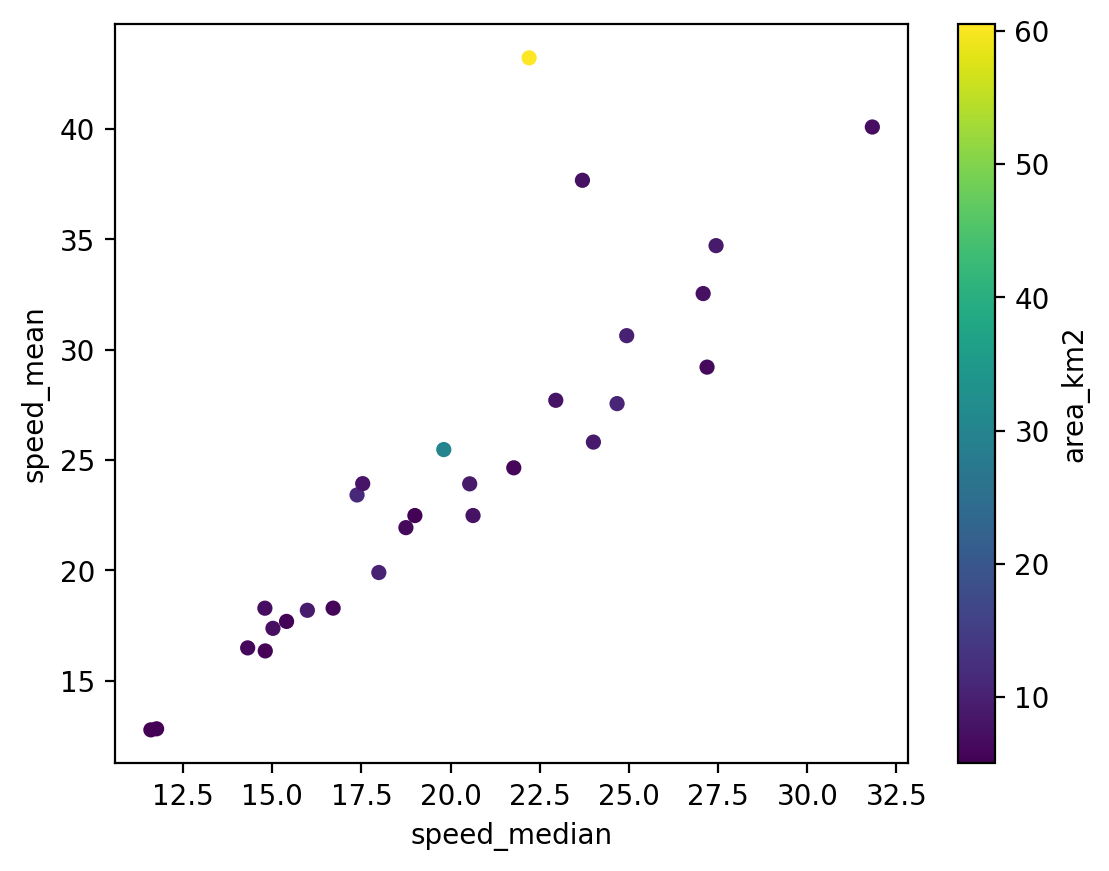

In [44]:
fig, ax = plt.subplots()
sc = rgi_itslive.plot.scatter(x='speed_median',y = 'speed_mean', c = 'area_km2', ax=ax)

Now we have a plot but there is still more information we'd like to include. For example, the labelling could be improved to show units. Changing the x-axis and y-axis labels of the pandas dataframe plot is pretty simple: 

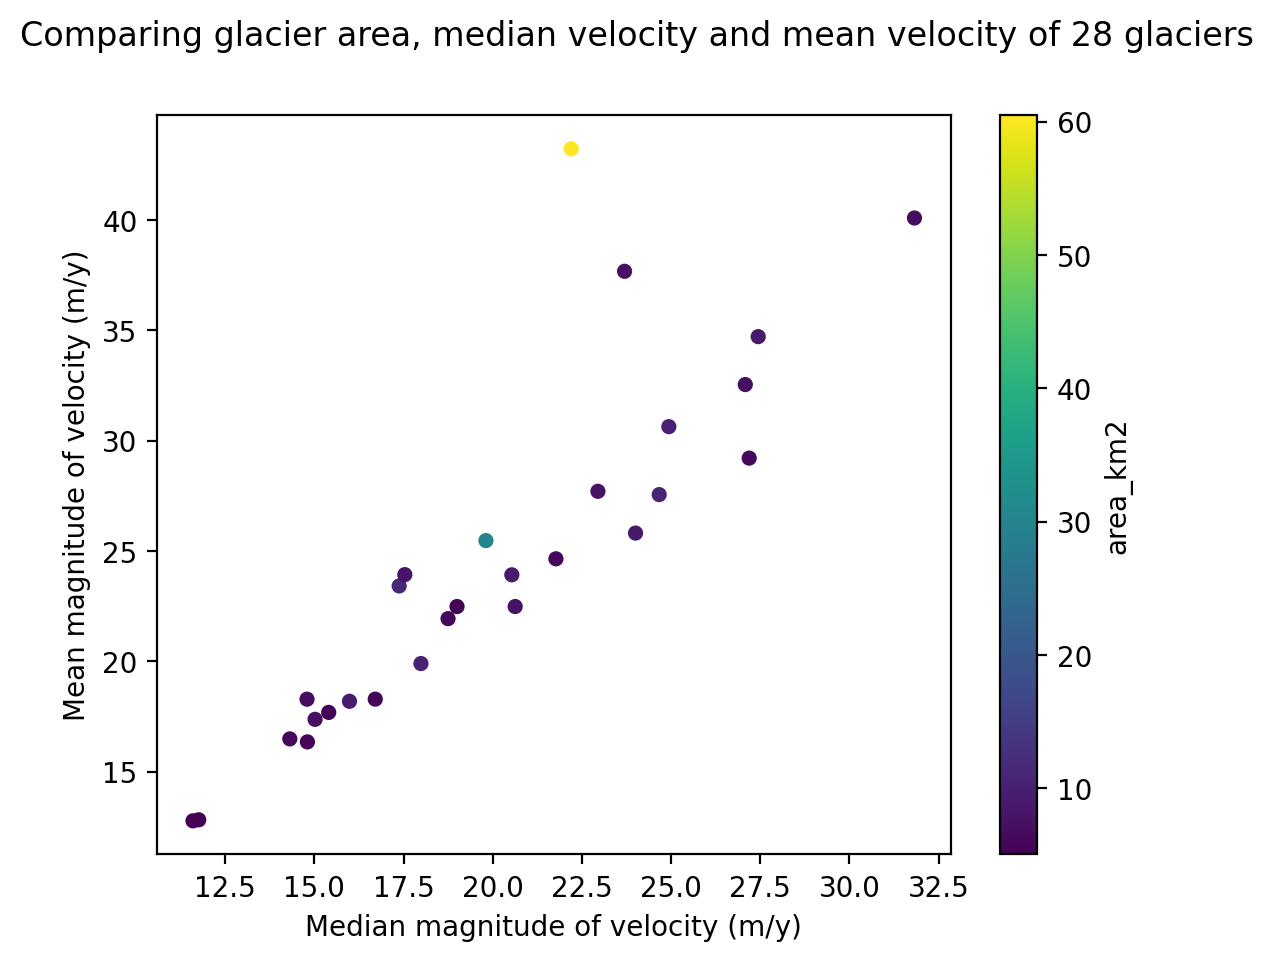

In [45]:
fig, ax = plt.subplots()
sc = rgi_itslive.plot.scatter(x='speed_median',y = 'speed_mean', c = 'area_km2', ax=ax)#.legend({'label':'test'})

fig.suptitle('Comparing glacier area, median velocity and mean velocity of 28 glaciers');
ax.set_ylabel('Mean magnitude of velocity (m/y)')
ax.set_xlabel('Median magnitude of velocity (m/y)');


But this could still be improved. The Colormap that describes the area variable in this plot would be more descriptive if it included units. 
Here is one way of editing the Colormap label:

In [46]:
#see what axes are in your fig object
fig.get_axes()


[<Axes: xlabel='Median magnitude of velocity (m/y)', ylabel='Mean magnitude of velocity (m/y)'>,
 <Axes: label='<colorbar>', ylabel='area_km2'>]

In [47]:
#extract the one we are interested in (colorbar)
cax = fig.get_axes()[1]
cax

<Axes: label='<colorbar>', ylabel='area_km2'>

In [48]:
#modify colorbar label
cax.set_ylabel('Area (sqare kilometer)')

Text(1102.9030555555557, 0.5, 'Area (sqare kilometer)')

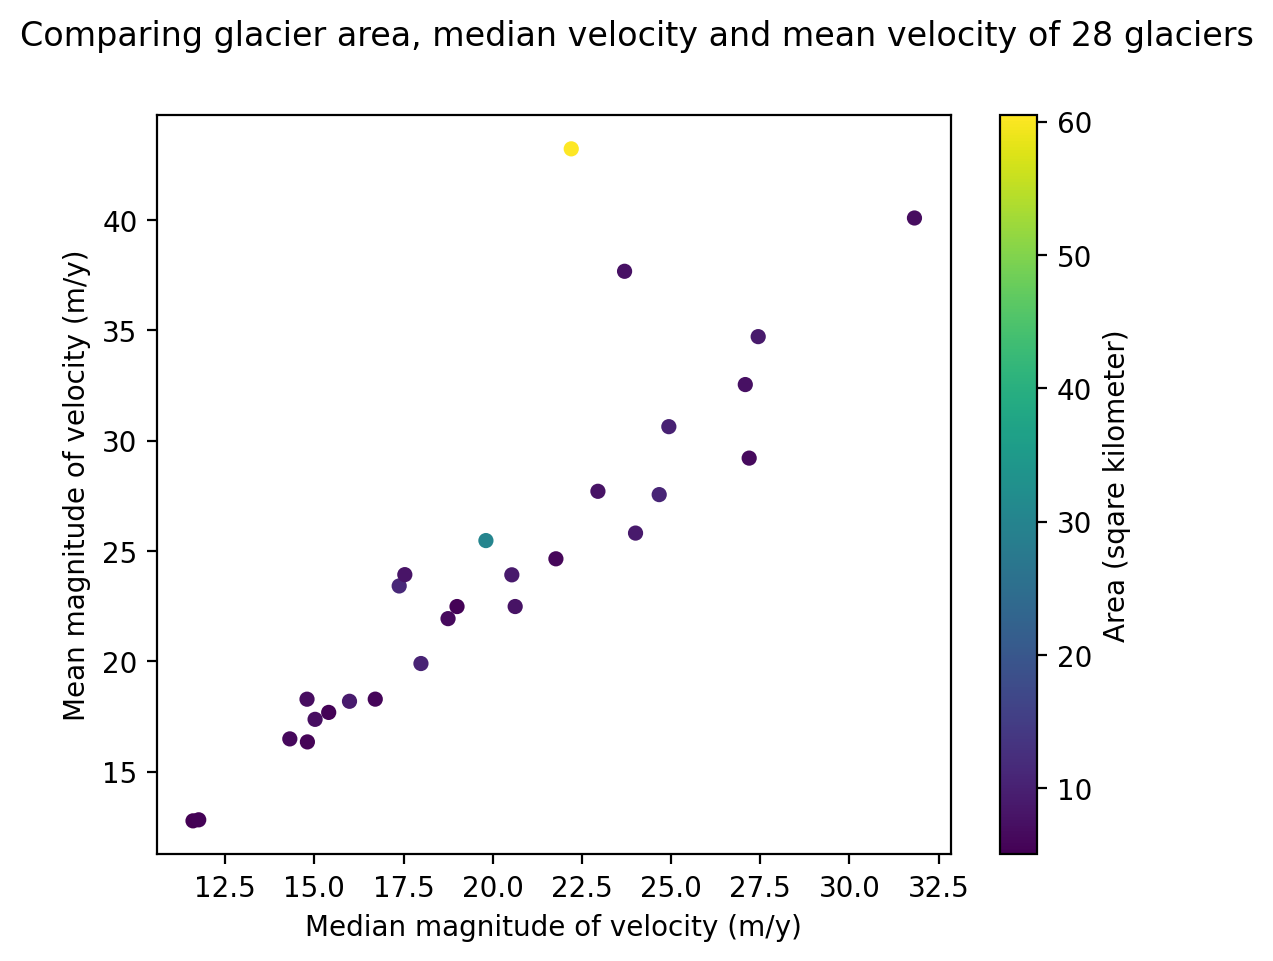

In [49]:
#all together
fig, ax = plt.subplots()
sc = rgi_itslive.plot.scatter(x='speed_median',y = 'speed_mean', c = 'area_km2', ax=ax)#.legend({'label':'test'})

fig.suptitle('Comparing glacier area, median velocity and mean velocity of 28 glaciers');
ax.set_ylabel('Mean magnitude of velocity (m/y)')
ax.set_xlabel('Median magnitude of velocity (m/y)');

cax = fig.get_axes()[1]
cax.set_ylabel('Area (sqare kilometer)');

### Geopandas plotting

In these plots, we are using the geometry information stored in the Geopandas.GeoDataFrame.

#### Static plots

Specify the variable you'd like to observe in the plot. Set `legend=True` to add the colormap and pass `legend_kwds` as a dictionary to change the label and set other characteristics of the legend object.

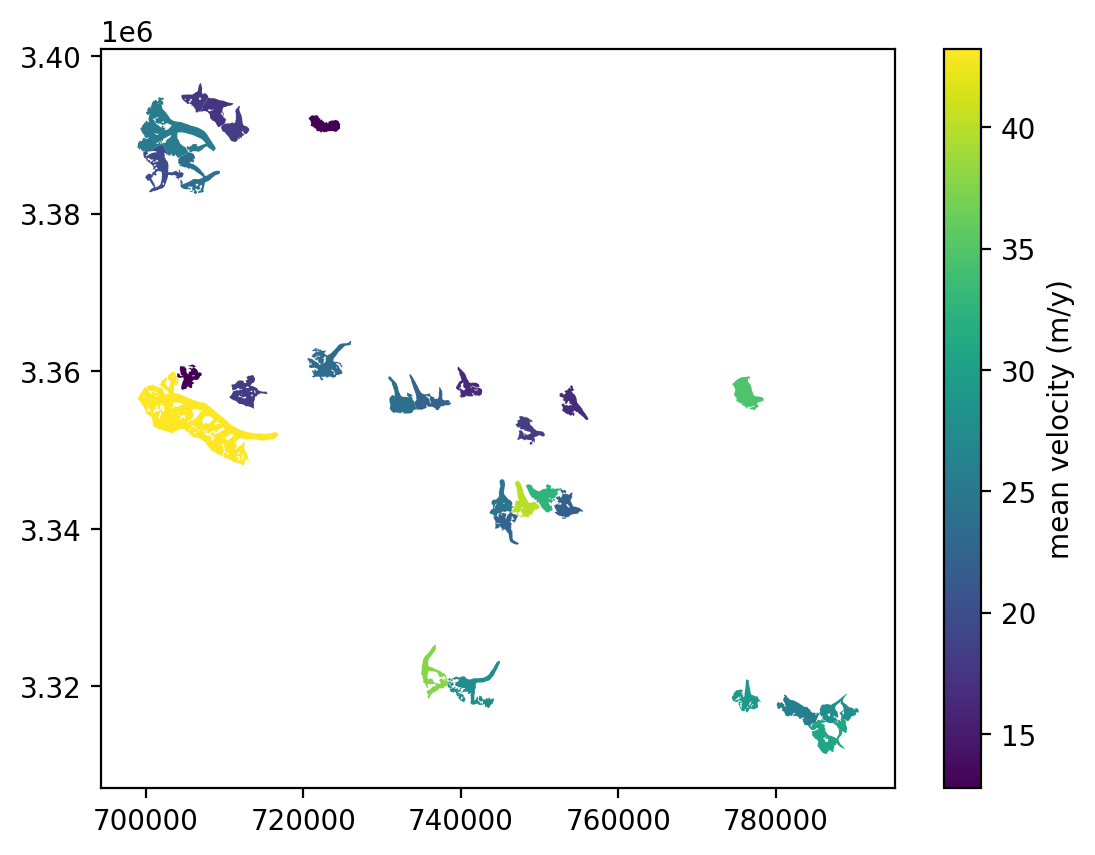

In [50]:
fig, ax = plt.subplots()
rgi_itslive.plot(ax=ax, column='speed_mean', legend=True,     
                 legend_kwds={"label": "mean velocity (m/y)", "orientation": "vertical"},);

#### Interactive plots 

The `geopandas.explore()` method returns an interactive map of a Geopandas.GeoDataFrame - cool! 

In [51]:
rgi_itslive.explore()

We can further customize the interactive plot:

In [53]:
rgi_itslive.explore('speed_median', cmap='inferno', style_kwds={'fillOpacity':0.7, 'stroke':False}, #stroke removes border around polygons, fillOpactiy sets opacity of polygons
                                                                                                   )

Awesome! We have encoded vector data onto a raster object that let's us examine raster data for multiple spatial units simultaneously and explore a number of ways to visualize this data.